02で前処理をしたデータの読み込みとモデルの学習を行うためのnotebookです。  
ここで作成したモデルは **src/models/** フォルダに格納して推論の際に使うようにして下さい。

## 必要なライブラリのimport

In [1]:
import warnings
import time
import pickle

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

In [ ]:
# データの読み込み
train = pd.read_csv('../data/processed/train_with_outlier_flag_probability.csv')
# 外れ値でないもののみ抽出
#train = train.query('outlier_flag == 0')

# 目的変数と説明変数の作成
# target = train['target'] # 目的変数
# # 説明変数からむだなtargetとflagとUnnamed(0列目)を削除
# del train['target'] 
#del train['outlier_flag']
#train = train.drop(train.columns[0],axis=1)


In [140]:
# データの読み込み
train = pd.read_csv('../data/processed/processed20240621_train.csv')
train_trueflag = pd.read_csv('../data/processed/processed20240620-1_train.csv')
train_flpr = pd.read_csv('../data/processed/train_with_outlier_flag_probability.csv')

In [9]:
train_trueflag = pd.read_csv('../data/processed/processed20240626_train.csv')

In [11]:
train_trueflag.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time,hist_transactions_count,hist_purchase_date_x,hist_latest_amount,hist_purchase_date_y,hist_category_1_sum,hist_category_1_mean,hist_category_1_mode,hist_category_2_1.0_mean,hist_category_2_1.0_mode,hist_category_2_2.0_mean,hist_category_2_2.0_mode,hist_category_2_3.0_mean,hist_category_2_3.0_mode,hist_category_2_4.0_mean,hist_category_2_4.0_mode,hist_category_2_5.0_mean,hist_category_2_5.0_mode,hist_category_3_A_mean,hist_category_3_A_mode,hist_category_3_B_mean,hist_category_3_B_mode,hist_category_3_C_mean,hist_category_3_C_mode,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_purchase_amount_mode,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_installments_mode,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_month_mode,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_purchase_date_mode,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_month_lag_mode,hist_month_diff_mean,hist_month_diff_max,hist_month_diff_min,month_rank,date_rank,auth_transactions_count,auth_purchase_date_x,auth_latest_amount,auth_purchase_date_y,auth_category_1_sum,auth_category_1_mean,auth_category_1_mode,auth_category_2_1.0_mean,auth_category_2_1.0_mode,auth_category_2_2.0_mean,auth_category_2_2.0_mode,auth_category_2_3.0_mean,auth_category_2_3.0_mode,auth_category_2_4.0_mean,auth_category_2_4.0_mode,auth_category_2_5.0_mean,auth_category_2_5.0_mode,auth_category_3_A_mean,auth_category_3_A_mode,auth_category_3_B_mean,auth_category_3_B_mode,auth_category_3_C_mean,auth_category_3_C_mode,auth_merchant_id_nunique,auth_merchant_category_id_nunique,auth_state_id_nunique,auth_city_id_nunique,auth_subsector_id_nunique,auth_purchase_amount_sum,auth_purchase_amount_mean,auth_purchase_amount_max,auth_purchase_amount_min,auth_purchase_amount_std,auth_purchase_amount_mode,auth_installments_sum,auth_installments_mean,auth_installments_max,auth_installments_min,auth_installments_std,auth_installments_mode,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_month_mode,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_purchase_date_mode,auth_month_lag_mean,auth_month_lag_max,auth_month_lag_min,auth_month_lag_std,auth_month_lag_mode,auth_month_diff_mean,auth_month_diff_max,auth_month_diff_min,new_transactions_count,new_purchase_date_x,new_latest_amount,new_purchase_date_y,new_category_1_sum,new_category_1_mean,new_category_1_mode,new_category_2_1.0_mean,new_category_2_1.0_mode,new_category_2_2.0_mean,new_category_2_2.0_mode,new_category_2_3.0_mean,new_category_2_3.0_mode,new_category_2_4.0_mean,new_category_2_4.0_mode,new_category_2_5.0_mean,new_category_2_5.0_mode,new_category_3_A_mean,new_category_3_A_mode,new_category_3_B_mean,new_category_3_B_mode,new_category_3_C_mean,new_category_3_C_mode,new_merchant_id_nunique,new_merchant_category_id_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_purchase_amount_mode,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_installments_mode,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_month_mode,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_purchase_date_mode,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_month_lag_mode,new_month_diff_mean,new_month_diff_max,new_month_diff_min

In [10]:
len(train_trueflag.columns)

235

In [93]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,elapsed_time,hist_transactions_count,hist_purchase_date_x,hist_latest_amount,hist_purchase_date_y,hist_category_1_sum,hist_category_1_mean,hist_category_1_mode,hist_category_2_1.0_mean,hist_category_2_1.0_mode,hist_category_2_2.0_mean,hist_category_2_2.0_mode,hist_category_2_3.0_mean,hist_category_2_3.0_mode,hist_category_2_4.0_mean,hist_category_2_4.0_mode,hist_category_2_5.0_mean,hist_category_2_5.0_mode,hist_category_3_A_mean,hist_category_3_A_mode,hist_category_3_B_mean,hist_category_3_B_mode,hist_category_3_C_mean,hist_category_3_C_mode,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_purchase_amount_mode,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_installments_mode,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_month_mode,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_purchase_date_mode,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_month_lag_mode,hist_month_diff_mean,hist_month_diff_max,hist_month_diff_min,month_rank,date_rank,auth_transactions_count,auth_purchase_date_x,auth_latest_amount,auth_purchase_date_y,auth_category_1_sum,auth_category_1_mean,auth_category_1_mode,auth_category_2_1.0_mean,auth_category_2_1.0_mode,auth_category_2_2.0_mean,auth_category_2_2.0_mode,auth_category_2_3.0_mean,auth_category_2_3.0_mode,auth_category_2_4.0_mean,auth_category_2_4.0_mode,auth_category_2_5.0_mean,auth_category_2_5.0_mode,auth_category_3_A_mean,auth_category_3_A_mode,auth_category_3_B_mean,auth_category_3_B_mode,auth_category_3_C_mean,auth_category_3_C_mode,auth_merchant_id_nunique,auth_merchant_category_id_nunique,auth_state_id_nunique,auth_city_id_nunique,auth_subsector_id_nunique,auth_purchase_amount_sum,auth_purchase_amount_mean,auth_purchase_amount_max,auth_purchase_amount_min,auth_purchase_amount_std,auth_purchase_amount_mode,auth_installments_sum,auth_installments_mean,auth_installments_max,auth_installments_min,auth_installments_std,auth_installments_mode,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_month_mode,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_purchase_date_mode,auth_month_lag_mean,auth_month_lag_max,auth_month_lag_min,auth_month_lag_std,auth_month_lag_mode,auth_month_diff_mean,auth_month_diff_max,auth_month_diff_min,new_transactions_count,new_purchase_date_x,new_latest_amount,new_purchase_date_y,new_category_1_sum,new_category_1_mean,new_category_1_mode,new_category_2_1.0_mean,new_category_2_1.0_mode,new_category_2_2.0_mean,new_category_2_2.0_mode,new_category_2_3.0_mean,new_category_2_3.0_mode,new_category_2_4.0_mean,new_category_2_4.0_mode,new_category_2_5.0_mean,new_category_2_5.0_mode,new_category_3_A_mean,new_category_3_A_mode,new_category_3_B_mean,new_category_3_B_mode,new_category_3_C_mean,new_category_3_C_mode,new_merchant_id_nunique,new_merchant_category_id_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_purchase_amount_mode,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_installments_mode,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_month_mode,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_purchase_date_mode,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_month_lag_mode,new_month_diff_mean,new_month_diff_max,new_month_d

In [96]:
train_trueflag.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,outlier_flag,elapsed_time,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_1_mode,hist_category_2_1.0_mean,hist_category_2_1.0_mode,hist_category_2_2.0_mean,hist_category_2_2.0_mode,hist_category_2_3.0_mean,hist_category_2_3.0_mode,hist_category_2_4.0_mean,hist_category_2_4.0_mode,hist_category_2_5.0_mean,hist_category_2_5.0_mode,hist_category_3_A_mean,hist_category_3_A_mode,hist_category_3_B_mean,hist_category_3_B_mode,hist_category_3_C_mean,hist_category_3_C_mode,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_purchase_amount_mode,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_installments_mode,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_month_mode,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_purchase_date_mode,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_month_lag_mode,hist_month_diff_mean,month_rank,date_rank,auth_transactions_count,auth_category_1_sum,auth_category_1_mean,auth_category_1_mode,auth_category_2_1.0_mean,auth_category_2_1.0_mode,auth_category_2_2.0_mean,auth_category_2_2.0_mode,auth_category_2_3.0_mean,auth_category_2_3.0_mode,auth_category_2_4.0_mean,auth_category_2_4.0_mode,auth_category_2_5.0_mean,auth_category_2_5.0_mode,auth_category_3_A_mean,auth_category_3_A_mode,auth_category_3_B_mean,auth_category_3_B_mode,auth_category_3_C_mean,auth_category_3_C_mode,auth_merchant_id_nunique,auth_merchant_category_id_nunique,auth_state_id_nunique,auth_city_id_nunique,auth_subsector_id_nunique,auth_purchase_amount_sum,auth_purchase_amount_mean,auth_purchase_amount_max,auth_purchase_amount_min,auth_purchase_amount_std,auth_purchase_amount_mode,auth_installments_sum,auth_installments_mean,auth_installments_max,auth_installments_min,auth_installments_std,auth_installments_mode,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_month_mode,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_purchase_date_mode,auth_month_lag_mean,auth_month_lag_max,auth_month_lag_min,auth_month_lag_std,auth_month_lag_mode,auth_month_diff_mean,new_transactions_count,new_category_1_sum,new_category_1_mean,new_category_1_mode,new_category_2_1.0_mean,new_category_2_1.0_mode,new_category_2_2.0_mean,new_category_2_2.0_mode,new_category_2_3.0_mean,new_category_2_3.0_mode,new_category_2_4.0_mean,new_category_2_4.0_mode,new_category_2_5.0_mean,new_category_2_5.0_mode,new_category_3_A_mean,new_category_3_A_mode,new_category_3_B_mean,new_category_3_B_mode,new_category_3_C_mean,new_category_3_C_mode,new_merchant_id_nunique,new_merchant_category_id_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_purchase_amount_mode,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_installments_mode,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_month_mode,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_purchase_date_mode,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_month_lag_mode,new_month_diff_mean,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_s

In [91]:
train_flpr.head()

,Unnamed: 0,first_active_month,feature_1,feature_2,feature_3,elapsed_time,hist_transactions_count,hist_purchase_date_x,hist_latest_amount,hist_purchase_date_y,hist_category_1_sum,hist_category_1_mean,hist_category_1_mode,hist_category_2_1.0_mean,hist_category_2_1.0_mode,hist_category_2_2.0_mean,hist_category_2_2.0_mode,hist_category_2_3.0_mean,hist_category_2_3.0_mode,hist_category_2_4.0_mean,hist_category_2_4.0_mode,hist_category_2_5.0_mean,hist_category_2_5.0_mode,hist_category_3_A_mean,hist_category_3_A_mode,hist_category_3_B_mean,hist_category_3_B_mode,hist_category_3_C_mean,hist_category_3_C_mode,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_purchase_amount_mode,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_installments_mode,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_month_mode,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_purchase_date_mode,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_month_lag_mode,hist_month_diff_mean,hist_month_diff_max,hist_month_diff_min,month_rank,date_rank,auth_transactions_count,auth_purchase_date_x,auth_latest_amount,auth_purchase_date_y,auth_category_1_sum,auth_category_1_mean,auth_category_1_mode,auth_category_2_1.0_mean,auth_category_2_1.0_mode,auth_category_2_2.0_mean,auth_category_2_2.0_mode,auth_category_2_3.0_mean,auth_category_2_3.0_mode,auth_category_2_4.0_mean,auth_category_2_4.0_mode,auth_category_2_5.0_mean,auth_category_2_5.0_mode,auth_category_3_A_mean,auth_category_3_A_mode,auth_category_3_B_mean,auth_category_3_B_mode,auth_category_3_C_mean,auth_category_3_C_mode,auth_merchant_id_nunique,auth_merchant_category_id_nunique,auth_state_id_nunique,auth_city_id_nunique,auth_subsector_id_nunique,auth_purchase_amount_sum,auth_purchase_amount_mean,auth_purchase_amount_max,auth_purchase_amount_min,auth_purchase_amount_std,auth_purchase_amount_mode,auth_installments_sum,auth_installments_mean,auth_installments_max,auth_installments_min,auth_installments_std,auth_installments_mode,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_month_mode,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_purchase_date_mode,auth_month_lag_mean,auth_month_lag_max,auth_month_lag_min,auth_month_lag_std,auth_month_lag_mode,auth_month_diff_mean,auth_month_diff_max,auth_month_diff_min,new_transactions_count,new_purchase_date_x,new_latest_amount,new_purchase_date_y,new_category_1_sum,new_category_1_mean,new_category_1_mode,new_category_2_1.0_mean,new_category_2_1.0_mode,new_category_2_2.0_mean,new_category_2_2.0_mode,new_category_2_3.0_mean,new_category_2_3.0_mode,new_category_2_4.0_mean,new_category_2_4.0_mode,new_category_2_5.0_mean,new_category_2_5.0_mode,new_category_3_A_mean,new_category_3_A_mode,new_category_3_B_mean,new_category_3_B_mode,new_category_3_C_mean,new_category_3_C_mode,new_merchant_id_nunique,new_merchant_category_id_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_purchase_amount_mode,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_installments_mode,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_month_mode,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_purchase_date_mode,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_month_lag_mode,new_month_diff_mean,new_month_diff_max,new_month_diff_

In [141]:
del train['first_active_month']
train_trueflag = train_trueflag['outlier_flag']
train = pd.concat([train,train_trueflag], axis = 1)

train_flpr = train_flpr[['first_active_month','outlier_flag', 'outlier_probability']]

#どれか消去
#del train['outlier_flag']
del train_flpr['outlier_flag']

del train_flpr['outlier_probability']

train = pd.concat([train,train_flpr], axis = 1)

In [144]:
train = train.query('outlier_flag == 0')

In [100]:
train.head(10)

,card_id,feature_1,feature_2,feature_3,target,elapsed_time,hist_transactions_count,hist_purchase_date_x,hist_latest_amount,hist_purchase_date_y,hist_category_1_sum,hist_category_1_mean,hist_category_1_mode,hist_category_2_1.0_mean,hist_category_2_1.0_mode,hist_category_2_2.0_mean,hist_category_2_2.0_mode,hist_category_2_3.0_mean,hist_category_2_3.0_mode,hist_category_2_4.0_mean,hist_category_2_4.0_mode,hist_category_2_5.0_mean,hist_category_2_5.0_mode,hist_category_3_A_mean,hist_category_3_A_mode,hist_category_3_B_mean,hist_category_3_B_mode,hist_category_3_C_mean,hist_category_3_C_mode,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_purchase_amount_mode,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_installments_mode,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_month_mode,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_purchase_date_mode,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_month_lag_mode,hist_month_diff_mean,hist_month_diff_max,hist_month_diff_min,month_rank,date_rank,auth_transactions_count,auth_purchase_date_x,auth_latest_amount,auth_purchase_date_y,auth_category_1_sum,auth_category_1_mean,auth_category_1_mode,auth_category_2_1.0_mean,auth_category_2_1.0_mode,auth_category_2_2.0_mean,auth_category_2_2.0_mode,auth_category_2_3.0_mean,auth_category_2_3.0_mode,auth_category_2_4.0_mean,auth_category_2_4.0_mode,auth_category_2_5.0_mean,auth_category_2_5.0_mode,auth_category_3_A_mean,auth_category_3_A_mode,auth_category_3_B_mean,auth_category_3_B_mode,auth_category_3_C_mean,auth_category_3_C_mode,auth_merchant_id_nunique,auth_merchant_category_id_nunique,auth_state_id_nunique,auth_city_id_nunique,auth_subsector_id_nunique,auth_purchase_amount_sum,auth_purchase_amount_mean,auth_purchase_amount_max,auth_purchase_amount_min,auth_purchase_amount_std,auth_purchase_amount_mode,auth_installments_sum,auth_installments_mean,auth_installments_max,auth_installments_min,auth_installments_std,auth_installments_mode,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_month_mode,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_purchase_date_mode,auth_month_lag_mean,auth_month_lag_max,auth_month_lag_min,auth_month_lag_std,auth_month_lag_mode,auth_month_diff_mean,auth_month_diff_max,auth_month_diff_min,new_transactions_count,new_purchase_date_x,new_latest_amount,new_purchase_date_y,new_category_1_sum,new_category_1_mean,new_category_1_mode,new_category_2_1.0_mean,new_category_2_1.0_mode,new_category_2_2.0_mean,new_category_2_2.0_mode,new_category_2_3.0_mean,new_category_2_3.0_mode,new_category_2_4.0_mean,new_category_2_4.0_mode,new_category_2_5.0_mean,new_category_2_5.0_mode,new_category_3_A_mean,new_category_3_A_mode,new_category_3_B_mean,new_category_3_B_mode,new_category_3_C_mean,new_category_3_C_mode,new_merchant_id_nunique,new_merchant_category_id_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_purchase_amount_mode,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_installments_mode,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_month_mode,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_purchase_date_mode,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_month_lag_mode,new_month_diff_mean,new_month_diff_max,new_month_diff_min,month_lag_m

In [145]:
len(train)

199710

In [62]:
len(train.query('outlier_flag == 1')) #/ len(train)

317

In [63]:
train.head()

,Unnamed: 0,first_active_month,feature_1,feature_2,feature_3,elapsed_time,hist_transactions_count,hist_purchase_date_x,hist_latest_amount,hist_purchase_date_y,hist_category_1_sum,hist_category_1_mean,hist_category_1_mode,hist_category_2_1.0_mean,hist_category_2_1.0_mode,hist_category_2_2.0_mean,hist_category_2_2.0_mode,hist_category_2_3.0_mean,hist_category_2_3.0_mode,hist_category_2_4.0_mean,hist_category_2_4.0_mode,hist_category_2_5.0_mean,hist_category_2_5.0_mode,hist_category_3_A_mean,hist_category_3_A_mode,hist_category_3_B_mean,hist_category_3_B_mode,hist_category_3_C_mean,hist_category_3_C_mode,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_purchase_amount_mode,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_installments_mode,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_month_mode,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_purchase_date_mode,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_month_lag_mode,hist_month_diff_mean,hist_month_diff_max,hist_month_diff_min,month_rank,date_rank,auth_transactions_count,auth_purchase_date_x,auth_latest_amount,auth_purchase_date_y,auth_category_1_sum,auth_category_1_mean,auth_category_1_mode,auth_category_2_1.0_mean,auth_category_2_1.0_mode,auth_category_2_2.0_mean,auth_category_2_2.0_mode,auth_category_2_3.0_mean,auth_category_2_3.0_mode,auth_category_2_4.0_mean,auth_category_2_4.0_mode,auth_category_2_5.0_mean,auth_category_2_5.0_mode,auth_category_3_A_mean,auth_category_3_A_mode,auth_category_3_B_mean,auth_category_3_B_mode,auth_category_3_C_mean,auth_category_3_C_mode,auth_merchant_id_nunique,auth_merchant_category_id_nunique,auth_state_id_nunique,auth_city_id_nunique,auth_subsector_id_nunique,auth_purchase_amount_sum,auth_purchase_amount_mean,auth_purchase_amount_max,auth_purchase_amount_min,auth_purchase_amount_std,auth_purchase_amount_mode,auth_installments_sum,auth_installments_mean,auth_installments_max,auth_installments_min,auth_installments_std,auth_installments_mode,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_month_mode,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_purchase_date_mode,auth_month_lag_mean,auth_month_lag_max,auth_month_lag_min,auth_month_lag_std,auth_month_lag_mode,auth_month_diff_mean,auth_month_diff_max,auth_month_diff_min,new_transactions_count,new_purchase_date_x,new_latest_amount,new_purchase_date_y,new_category_1_sum,new_category_1_mean,new_category_1_mode,new_category_2_1.0_mean,new_category_2_1.0_mode,new_category_2_2.0_mean,new_category_2_2.0_mode,new_category_2_3.0_mean,new_category_2_3.0_mode,new_category_2_4.0_mean,new_category_2_4.0_mode,new_category_2_5.0_mean,new_category_2_5.0_mode,new_category_3_A_mean,new_category_3_A_mode,new_category_3_B_mean,new_category_3_B_mode,new_category_3_C_mean,new_category_3_C_mode,new_merchant_id_nunique,new_merchant_category_id_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_purchase_amount_mode,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_installments_mode,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_month_mode,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_purchase_date_mode,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_month_lag_mode,new_month_diff_mean,new_month_diff_max,new_month_diff_

In [146]:
# 目的変数と説明変数の作成
target = train['target'] # 目的変数
# # 説明変数からむだなtargetとoutlierとUnnamed(0列目)を削除
del train['target'] 

#train = train.drop(train.columns[0],axis=1)

In [120]:
train.head(10)

,first_active_month,feature_1,feature_2,feature_3,elapsed_time,hist_transactions_count,hist_purchase_date_x,hist_latest_amount,hist_purchase_date_y,hist_category_1_sum,hist_category_1_mean,hist_category_1_mode,hist_category_2_1.0_mean,hist_category_2_1.0_mode,hist_category_2_2.0_mean,hist_category_2_2.0_mode,hist_category_2_3.0_mean,hist_category_2_3.0_mode,hist_category_2_4.0_mean,hist_category_2_4.0_mode,hist_category_2_5.0_mean,hist_category_2_5.0_mode,hist_category_3_A_mean,hist_category_3_A_mode,hist_category_3_B_mean,hist_category_3_B_mode,hist_category_3_C_mean,hist_category_3_C_mode,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_purchase_amount_mode,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_installments_mode,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_month_mode,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_purchase_date_mode,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_month_lag_mode,hist_month_diff_mean,hist_month_diff_max,hist_month_diff_min,month_rank,date_rank,auth_transactions_count,auth_purchase_date_x,auth_latest_amount,auth_purchase_date_y,auth_category_1_sum,auth_category_1_mean,auth_category_1_mode,auth_category_2_1.0_mean,auth_category_2_1.0_mode,auth_category_2_2.0_mean,auth_category_2_2.0_mode,auth_category_2_3.0_mean,auth_category_2_3.0_mode,auth_category_2_4.0_mean,auth_category_2_4.0_mode,auth_category_2_5.0_mean,auth_category_2_5.0_mode,auth_category_3_A_mean,auth_category_3_A_mode,auth_category_3_B_mean,auth_category_3_B_mode,auth_category_3_C_mean,auth_category_3_C_mode,auth_merchant_id_nunique,auth_merchant_category_id_nunique,auth_state_id_nunique,auth_city_id_nunique,auth_subsector_id_nunique,auth_purchase_amount_sum,auth_purchase_amount_mean,auth_purchase_amount_max,auth_purchase_amount_min,auth_purchase_amount_std,auth_purchase_amount_mode,auth_installments_sum,auth_installments_mean,auth_installments_max,auth_installments_min,auth_installments_std,auth_installments_mode,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_month_mode,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_purchase_date_mode,auth_month_lag_mean,auth_month_lag_max,auth_month_lag_min,auth_month_lag_std,auth_month_lag_mode,auth_month_diff_mean,auth_month_diff_max,auth_month_diff_min,new_transactions_count,new_purchase_date_x,new_latest_amount,new_purchase_date_y,new_category_1_sum,new_category_1_mean,new_category_1_mode,new_category_2_1.0_mean,new_category_2_1.0_mode,new_category_2_2.0_mean,new_category_2_2.0_mode,new_category_2_3.0_mean,new_category_2_3.0_mode,new_category_2_4.0_mean,new_category_2_4.0_mode,new_category_2_5.0_mean,new_category_2_5.0_mode,new_category_3_A_mean,new_category_3_A_mode,new_category_3_B_mean,new_category_3_B_mode,new_category_3_C_mean,new_category_3_C_mode,new_merchant_id_nunique,new_merchant_category_id_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_purchase_amount_mode,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_installments_mode,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_month_mode,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_purchase_date_mode,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_month_lag_mode,new_month_diff_mean,new_month_diff_max,new_month_diff_min,month_l

グリッドサーチの話

In [147]:
from sklearn.model_selection import GridSearchCV

In [148]:
# グリッドサーチ　
# lightgbmのパラメータ
param_grid = {'num_leaves': [111,130,150,170],
         'min_data_in_leaf': [149], 
         'objective':['regression'],
         'max_depth': [9,12,20],
         'learning_rate': [0.005],
         "boosting": ["gbdt"],
         "feature_fraction": [0.7522],
         "bagging_freq": [1],
         "bagging_fraction": [0.7083] ,
         "bagging_seed": [11],
         "metric": ['rmse'],
         "lambda_l1": [0.2634],
         "random_state": [133],
         "verbosity": [-1]}

In [149]:
from sklearn.metrics import make_scorer, mean_squared_error

# 評価指標の設定（平均二乗誤差の負の値）
scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [150]:
del train['card_id']
#del train['first_active_month']

In [152]:
from sklearn.model_selection import GridSearchCV

# LightGBMモデルの初期化
model = lgb.LGBMRegressor()

# グリッドサーチの設定
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=5, verbose=2)

# グリッドサーチの実行
grid_search.fit(train, target)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END bagging_fraction=0.7083, bagging_freq=1, bagging_seed=11, boosting=gbdt, feature_fraction=0.7522, lambda_l1=0.2634, learning_rate=0.005, max_depth=9, metric=rmse, min_data_in_leaf=149, num_leaves=111, objective=regression, random_state=133, verbosity=-1; total time=   6.9s
[CV] END bagging_fraction=0.7083, bagging_freq=1, bagging_seed=11, boosting=gbdt, feature_fraction=0.7522, lambda_l1=0.2634, learning_rate=0.005, max_depth=9, metric=rmse, min_data_in_leaf=149, num_leaves=111, objective=regression, random_state=133, verbosity=-1; total time=   6.1s
[CV] END bagging_fraction=0.7083, bagging_freq=1, bagging_seed=11, boosting=gbdt, feature_fraction=0.7522, lambda_l1=0.2634, learning_rate=0.005, max_depth=9, metric=rmse, min_data_in_leaf=149, num_leaves=111, objective=regression, random_state=133, verbosity=-1; total time=   5.2s
[CV] END bagging_fraction=0.7083, bagging_freq=1, bagging_seed=11, boosting=gbdt, feature_

GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'bagging_fraction': [0.7083], 'bagging_freq': [1],
                         'bagging_seed': [11], 'boosting': ['gbdt'],
                         'feature_fraction': [0.7522], 'lambda_l1': [0.2634],
                         'learning_rate': [0.005], 'max_depth': [9, 12, 20],
                         'metric': ['rmse'], 'min_data_in_leaf': [149],
                         'num_leaves': [111, 130, 150, 170],
                         'objective': ['regression'], 'random_state': [133],
                         'verbosity': [-1]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, response_method='predict'),
             verbose=2)

グリッドサーチ終わり

In [153]:
# lightgbmのパラメータ
param = {'num_leaves': 170, #50, #111
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 12, #9
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [154]:
# 特徴量の情報
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = ['feature_1','feature_2', 'feature_3']

In [155]:
# データをKFoldで5分割して学習
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
#predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(params=param,
                    train_set=trn_data,
                    num_boost_round=num_round,
                    valid_sets=[val_data],
                    callbacks=[lgb.early_stopping(stopping_rounds=200),
                               lgb.log_evaluation(100)])

    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # モデルを保存
    with open(f'../src/models/modelq3-0_fold_{fold_}.pkl', 'wb') as f:
        pickle.dump(clf, f)

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 1.63815
[200]	valid_0's rmse: 1.60178
[300]	valid_0's rmse: 1.58443
[400]	valid_0's rmse: 1.57551
[500]	valid_0's rmse: 1.57021
[600]	valid_0's rmse: 1.56699
[700]	valid_0's rmse: 1.56501
[800]	valid_0's rmse: 1.56364
[900]	valid_0's rmse: 1.56271
[1000]	valid_0's rmse: 1.56188
[1100]	valid_0's rmse: 1.56138
[1200]	valid_0's rmse: 1.56102
[1300]	valid_0's rmse: 1.56082
[1400]	valid_0's rmse: 1.56067
[1500]	valid_0's rmse: 1.56058
[1600]	valid_0's rmse: 1.56052
[1700]	valid_0's rmse: 1.5605
[1800]	valid_0's rmse: 1.5605
[1900]	valid_0's rmse: 1.56051
Early stopping, best iteration is:
[1752]	valid_0's rmse: 1.56047
fold n°1
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 1.63688
[200]	valid_0's rmse: 1.59949
[300]	valid_0's rmse: 1.58157
[400]	valid_0's rmse: 1.57203
[500]	valid_0's rmse: 1.56651
[600]	valid_0's rmse: 1.56322
[700]	valid_0's rmse: 1.56144
[800

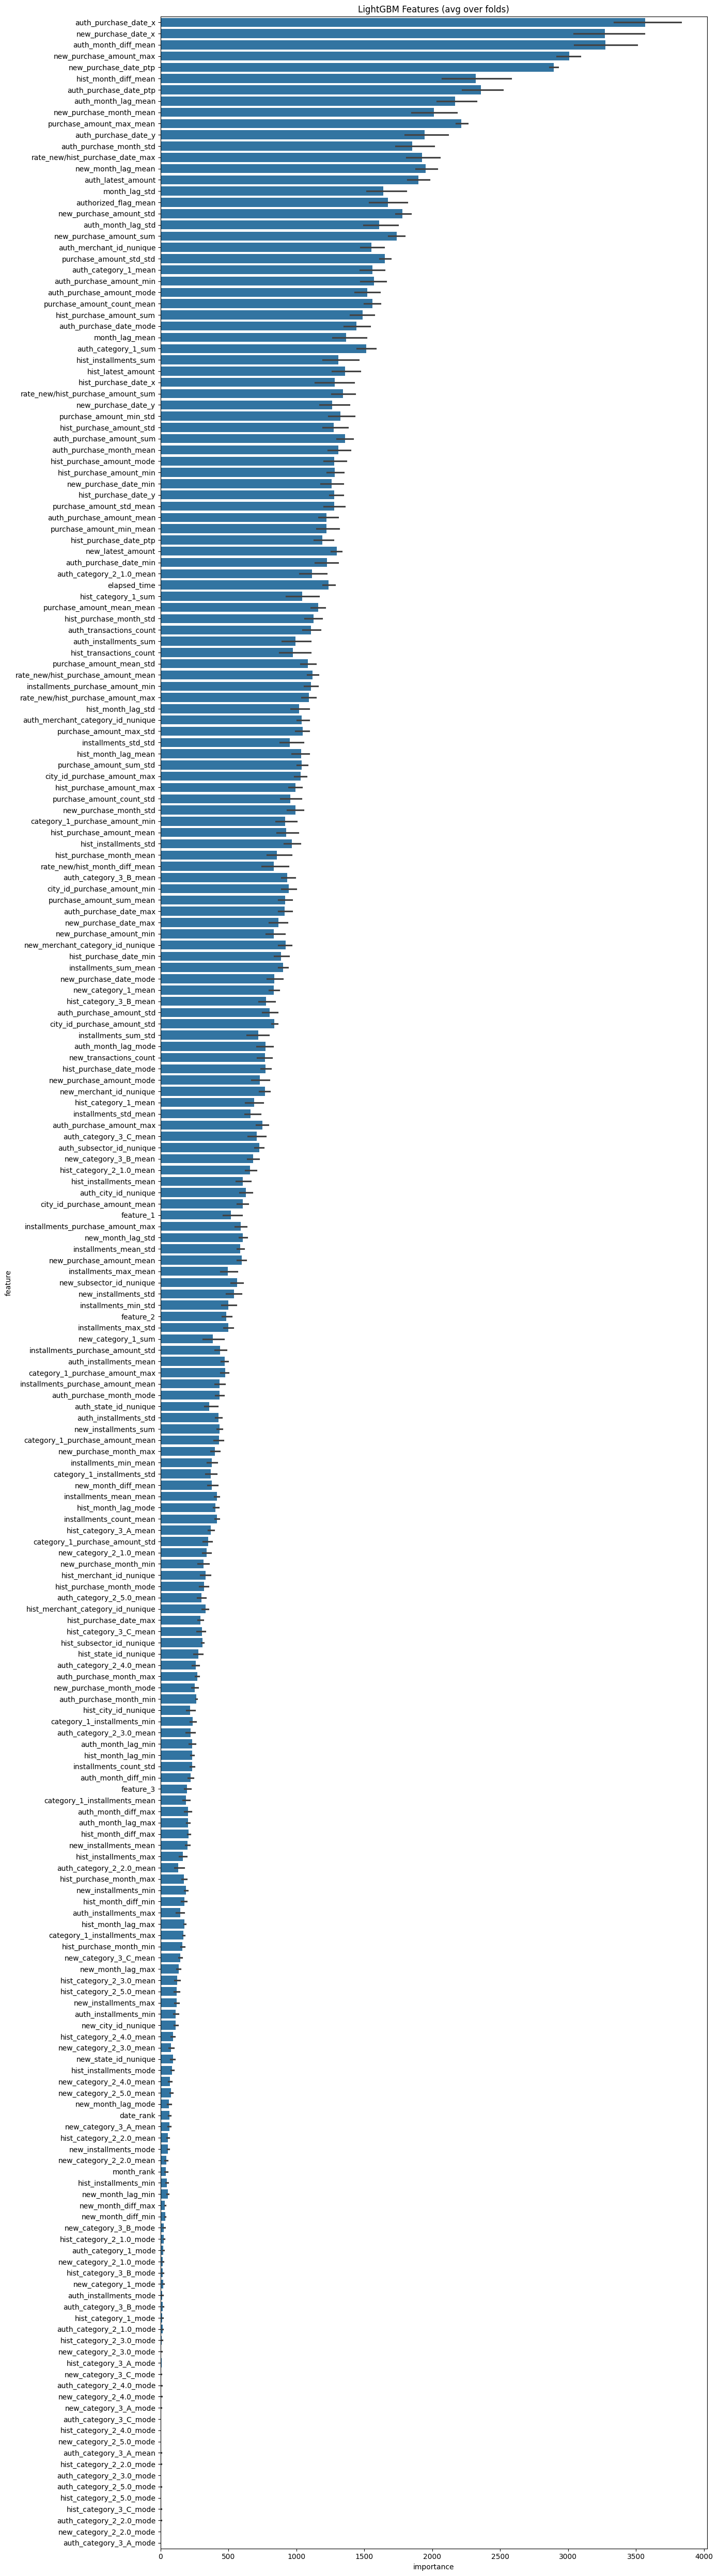

In [13]:
# 特徴量重要度の可視化

cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')

In [15]:
len(cols)

211

In [30]:
# 特徴量の重要度を平均して、重要度が高い順にソートし、上位100個の特徴量を選択する
top_features = feature_importance_df.groupby("feature")["importance"].mean().sort_values(ascending=False).head(100).index.tolist()

df_top_100_teatures = pd.DataFrame(top_features)

# # 上位100個の特徴量を抽出する
# top_100_features = top_features["feature"]

# # 特徴量のデータフレームを表示する
# print(top_100_features)

In [31]:
df_top_100_teatures.to_csv("top_100_features.csv", index=False)

In [55]:
# 特徴量の重要度を平均して、重要度が高い順にソートsuru
top_features = feature_importance_df.groupby("feature")["importance"].mean().sort_values(ascending=False).index.tolist()

top_features = pd.DataFrame(top_features)

top_features.to_csv("top_features_sort.csv", index=False)